In [1]:
import sys, os, random

# Get the parent directory and add it to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from Utils import utils

import yfinance as yf, datetime as dt
import matplotlib.pyplot as plt
import numpy as np, pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor

import ta, warnings, pdb
warnings.filterwarnings('ignore')

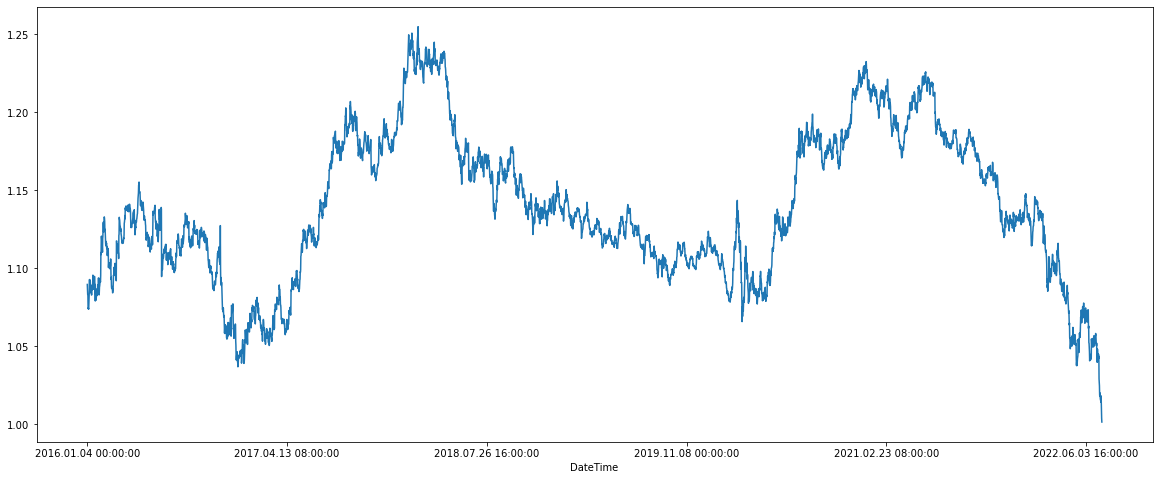

,Open,High,Low,Close,Volume,Median
DateTime,,,,,,
2016.01.04 00:00:00,1.08696,1.09046,1.08270,1.08970,30550,1.086580
2016.01.04 08:00:00,1.08970,1.09462,1.08452,1.08543,66270,1.089570
2016.01.04 16:00:00,1.08544,1.08627,1.07808,1.08319,60867,1.082175
2016.01.05 00:00:00,1.08274,1.08386,1.08147,1.08309,22455,1.082665
2016.01.05 08:00:00,1.08309,1.08362,1.07388,1.07417,60775,1.078750


In [2]:
#folder, ticker, period, startdatetime, enddatetime = 'CSVData', 'EURUSD', 'Weekly', '201001100000', '202201020000'
#folder, ticker, period, startdatetime, enddatetime = 'CSVData', 'EURUSD', 'Daily', '201701020000', '202207120000'
folder, ticker, period, startdatetime, enddatetime = 'CSVData', 'EURUSD', 'H8', '201601040000', '202207120000'
multiplier = 100 if 'JPY' in ticker else 10000
ohlcv = pd.read_csv('../'+folder+'/'+ticker+'_'+period+'_'+startdatetime+'_'+enddatetime+'.csv', delimiter='\t')
ohlcv = utils.prep_metatrader_data(ohlcv)
plt.figure(figsize=(20,8))
ohlcv['Close'].plot()
plt.show()
ohlcv.head(5)

In [8]:
ohlcv['diff_o_h'] = round((ohlcv['High'] - ohlcv['Open'])*10000,2)
ohlcv['diff_o_l'] = round((ohlcv['Open'] - ohlcv['Low'])*10000,2)
ohlcv['diff_o_c'] = round((ohlcv['Close'] - ohlcv['Open'])*10000,2)
ohlcv['dir'] = ohlcv.apply(lambda x: 'UP' if x['Close'] > x['Open'] else 'DOWN', axis=1)

rand_hit_df = pd.DataFrame({
    'dir': ohlcv['dir'],
    'ol': ohlcv['diff_o_l'],
    'oh': ohlcv['diff_o_h'],
    'oc': ohlcv['diff_o_c']
})

In [9]:
period, divisor = 8, 6
rand_hit_df = rand_hit_df.assign(earnings=0, guess='', correct=None)
rand_hit_df['val'] = (rand_hit_df['ol']+rand_hit_df['oh']).rolling(window=period, min_periods=1).mean().shift()
rand_hit_df['val'] = round(rand_hit_df['val']/divisor)
rand_hit_df = rand_hit_df.iloc[period:]

In [10]:
for index, row in rand_hit_df.iterrows():
    val = row['val'] 
    guess = random.choice(['UP', 'DOWN'])
    rand_hit_df.loc[index, 'guess'] = guess
    rand_hit_df.loc[index, 'correct'] = guess == row['dir']
    
    if guess == 'UP':
        rand_hit_df.loc[index, 'earnings'] = val if row['oh'] >= val else row['oc']
        
    elif guess == 'DOWN':
        rand_hit_df.loc[index, 'earnings'] = val if row['ol'] >= val else row['oc']*-1

display(rand_hit_df.head())
print(f"Total pips: {round(sum(rand_hit_df['earnings']),2)}")
print(f"Correct dir pct: {round(sum(rand_hit_df['correct'])/len(rand_hit_df)*100,2)}")
print(f"Positive pips pct: {round(sum(rand_hit_df['earnings']>0)/len(rand_hit_df)*100,2)}")
print(f"Total pips if no negative: {round(sum(rand_hit_df[rand_hit_df['earnings']>=0]['earnings']),2)}")

,dir,ol,oh,oc,earnings,guess,correct,val
DateTime,,,,,,,,
2016.01.06 16:00:00,UP,6.3,60.3,40.7,-40.7,DOWN,False,11.0
2016.01.07 00:00:00,UP,5.5,50.3,48.0,-48.0,DOWN,False,10.0
2016.01.07 08:00:00,UP,56.2,47.4,31.4,9.0,DOWN,False,9.0
2016.01.07 16:00:00,UP,32.5,81.7,70.5,10.0,DOWN,False,10.0
2016.01.08 00:00:00,DOWN,53.0,8.8,-46.6,-46.6,UP,False,12.0


Total pips: -1471.1
Correct dir pct: 49.78
Positive pips pct: 76.36
Total pips if no negative: 26646.7


In [6]:
len(rand_hit_df)

5075